<a href="https://colab.research.google.com/github/gbwiersum/CLApartmentScraper/blob/main/CLScraper7_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from google.colab import drive
drive.mount('/content/drive')

# Defining methods:
#building the scraping engine. 


1.   Gets each page of listings
2.   For each page of listings, gets attributes and headline descriptions, sqft, rent and a url for the posting.
3. For each url, opens and scrapes all information.



In [2]:
#!apt update
#!apt upgrade
!pip install selenium -q
!apt install chromium-chromedriver -y -q
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import datetime
import pandas as pd
import re

#Listing object holds all information relevant to the post. Non normalized, Has redundancy.

class Listing:

  def __init__(self, url):
    self.url = url
    browser = start_browser()
    browser.get(url)
    self.ID = _xml_getter(url, before = "/", after=".html")[-10::]

    try:
      self.html = BeautifulSoup(browser.page_source)
    except:
      try:
        time.sleep(1)
        browser.get(url)
        time.sleep(1)
        self.html=BeautifulSoup(browser.page_source)
      except:
        pass

    def parse_attributes(self):


      def get_price(self):
        try:
          price = self.html.find('span', class_='price').text
          price = re.sub(r'[^\d.]', '', str(price))
          return(int(price))
        except:
          return(None)
        

      def get_beds(self):
        housing = self.html.find("span", class_='housing')
        if housing is not None:
          beds = _xml_getter(housing.text.lower(), before=' ', after="br")
        else:
          beds = 0
        return(beds)

      def get_sqft(self):
        housing = self.html.find('span', class_='housing')
        if housing is not None:
          sqft =_xml_getter(housing.text.lower(), before=' - ', after="ft2")
          if sqft is not None:
            sqft = int(sqft)
          else: sqft = None
        else: sqft = None
        return(sqft)

      def get_park(self):
        park = _xml_getter(self.html, before='>', after="parking")
        return(park)

      def get_baths(self):
        bedbath = self.html.find('span', class_='shared-line-bubble')
        if bedbath is not None:
          baths = _xml_getter(bedbath.text.lower(), before="/ ", after='ba')
          return(baths)
        else: return None

      def get_body(self):
        body = self.html.find('section', id='postingbody')
        if body is not None:
          body = body.text
          body = body.replace("\n\nQR Code Link to This Post\n\n\n", "")
          body = body.replace("\n", " ")
          return(body)
        else: return " "

      def get_address(self):
        address = self.html.find('div', class_='mapaddress')
        if address is not None:
          location = address.text
        else: location = None
        return(location)

      def get_lat_lon(self):
        try:  
          lat = self.html.find('div', id='map').get('data-latitude')
          lon = self.html.find('div', id='map').get('data-longitude')
          lat = float(lat)
          lon = float(lon)
        except:
          lat=None
          lon=None

        return(lat, lon)

      def get_attrgroup(self):
        attrgroup = self.html.find('div', class_='mapAndAttrs')
        attrlist = ['cats are OK - purrr', 'dogs are OK - wooof', 'air conditioning', 
        'furnished', 'w/d in unit', 'laundry on site', 'laundry in bldg', 
        'no laundry on site', 'no parking', 'street parking', 'off-street parking', 
        'detached garage']
        if attrgroup is not None:
          attrgroup.find_all('p', class_='attrgroup')[1]
          attrgroup = set(attrgroup.text.split("\n"))
          attrvals = []
          for attr in attrlist:
            if attr in attrgroup:
              attrvals.append(1)
            else:
              attrvals.append(0)

          return(attrvals)
        else: return [0]*(len(attrlist))


      def get_date(self):
        return _xml_getter(self.html.find('time'), before='title="', after = '"')

      self.price = get_price(self)  
      self.beds = get_beds(self)
      self.sqft = get_sqft(self)
      self.park = get_park(self)
      self.baths = get_baths(self)
      self.body = get_body(self)
      self.address = get_address(self)
      self.lat, self.lon = get_lat_lon(self)
      self.attrgroup = get_attrgroup(self)
      self.date = get_date(self)

    parse_attributes(self)

  def get_attribute_dict(self):
    attrs = [self.url, self.price, self.beds, self.sqft, self.park, self.baths, 
     self.body, self.address, self.lat, self.lon, self.date]+self.attrgroup
    attrdict = {self.ID: attrs}
    return attrdict



def start_browser():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  #chrome_options.add_argument('--disable-dev-shm-usage')
  browser = webdriver.Chrome('chromedriver', options=chrome_options)
  browser.set_window_size(48, 32)
  return(browser)

#utility to pull variables out of xml data using leading and following tag.
#I refusue to learn regex and this is my workaround for that.
def _xml_getter(text, before="", after=""):
  if text is not None:
    text = str(text)
    m = re.search(before+'(.+?)'+after, text)
    if m:
        found = m.group(1).strip()
        return(found)
  else: return None

  #Gets all listings for a given search query. If I had a main, this would be it.
#Pages come in batches of 120. Pass "-1" to pages for all.
def get_listings(start_url, pages=-1, cooldown=0):
  try:
    browser = start_browser()
    results = {}
    if pages == -1:
      try:
        browser.get(start_url)
        end = int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text)
      except:
        end = 2880
    else:
      end = pages*120

    for n in range(0, end, 120):
        if n>0:
          browser.get((start_url+'&s='+str(n)))
        else:
          time.sleep(cooldown)
          browser.get(start_url)

        #Debug: 
        pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
        pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
        print("Processing: "+pagestart+" through " + pageend)
        #####

        listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
        for l in listings:
          html = l.get_attribute('innerHTML')
          #results.update(attributes)
          url = BeautifulSoup(html).a.get('href')
          results.update(Listing(url).get_attribute_dict())

    return(results)
  except:
    return results

In [4]:
#@title To use, perform a search on craigslist and copy the URL here. Enter the number of pages of results you want, -1 for all. Start small -- more pages takes more time.
start_url = "https://chicago.craigslist.org/search/apa" #@param {type:"string"}
pages =  1 #@param {type:"integer"}
listings = get_listings(start_url, pages)
listingdf = pd.DataFrame.from_dict(listings, orient='index')

listingdf.columns = ['url', 'price', 'beds', 'sqft', 'parking', 'baths', 'descript', 'adress', 'lat', 'lon', 'date', 
                     'cats are OK - purrr', 'dogs are OK - wooof', 'air conditioning', 
              'furnished', 'w/d in unit', 'laundry on site', 'laundry in bldg', 
              'no laundry on site', 'no parking', 'street parking', 'off-street parking', 
              'detached garage']
listingdf['laundry on site'] = listingdf['laundry on site']+listingdf['laundry in bldg']
listingdf.drop(columns='laundry in bldg', inplace = True)
listingdf['no parking'] = listingdf['no parking']+listingdf['street parking']
listingdf.drop(columns='street parking', inplace=True)
listingdf['dpsf'] = 1/(listingdf['sqft']/listingdf['price'])
listingdf.drop_duplicates(inplace=True)
listingdf.head()

Processing: 1 through 120
Processing: 121 through 240
Processing: 241 through 259


,url,price,beds,sqft,parking,baths,descript,adress,lat,lon,...,dogs are OK - wooof,air conditioning,furnished,w/d in unit,laundry on site,no laundry on site,no parking,off-street parking,detached garage,dpsf
7511599909,https://chicago.craigslist.org/chc/apa/d/chica...,1195,None,NaN,street,1,Great studio available! Property Addres...,2330 n spaulding ave,41.923454,-87.710564,...,1,0,0,0,1,0,1,0,0,NaN
7511570375,https://chicago.craigslist.org/chc/apa/d/chica...,995,0,NaN,street,1,Great studio available! Property Address...,1742 n humboldt blvd,41.912579,-87.702736,...,0,0,0,0,1,0,1,0,0,NaN
7511566852,https://chicago.craigslist.org/chc/apa/d/chica...,995,0,NaN,street,1,Great studio available! Property Address...,1627 n humboldt blvd,41.910749,-87.701740,...,0,0,0,0,1,0,1,0,0,NaN
7511528323,https://chicago.craigslist.org/chc/apa/d/chica...,1200,2,NaN,street,1,The apartments 2701 N. Troy / 3120 W. Schubert...,2701 N Troy St,41.930156,-87.706107,...,0,0,0,0,0,1,1,0,0,NaN
7511527525,https://chicago.craigslist.org/chc/apa/d/chica...,2395,3,NaN,street,1,"PROPERTY INFO ID: 275928130Rent: $2,395 / Mont...",2823 West Logan Blvd,41.928033,-87.698439,...,1,0,0,0,1,0,1,0,0,NaN


# Analysis

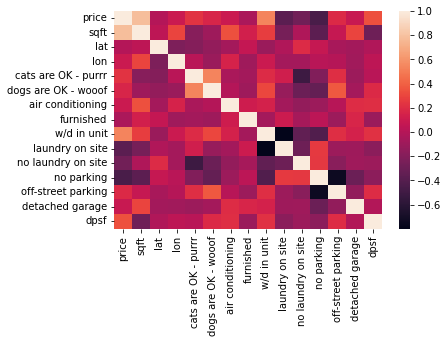

In [5]:
import seaborn as sns
sns.heatmap(listingdf.corr())

In [6]:
listingdf.corr()['dpsf'].sort_values()
#The best thing you can do for rents is be further east.
#The worst thing, is to not have a w/d
#The next best thing after location is allowing pets or putting in an in-unit w/d

sqft                  -0.285516
laundry on site       -0.172309
no parking            -0.158782
furnished             -0.107218
no laundry on site    -0.097343
lat                   -0.016804
detached garage       -0.009885
cats are OK - purrr    0.019626
lon                    0.041047
dogs are OK - wooof    0.190305
off-street parking     0.206401
air conditioning       0.210139
w/d in unit            0.222386
price                  0.342203
dpsf                   1.000000
Name: dpsf, dtype: float64

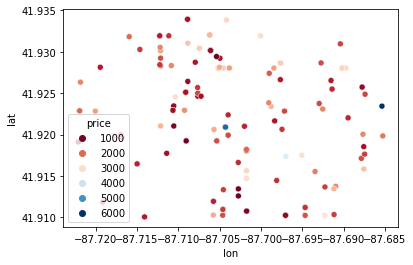

In [7]:
import matplotlib.pyplot as plt

sns.scatterplot(y='lat', x='lon', hue='price', data=listingdf[['price', 'lat', 'lon']], palette='RdBu')
plt.figsize=(80,80)

2685.3836130766595


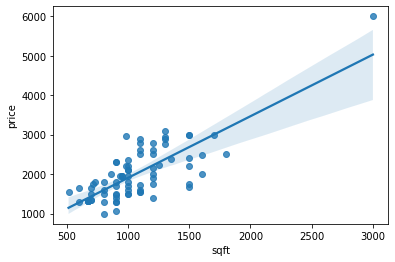

In [16]:
#@title Linear model: Enter square footage (number)
sqft = 1500 #@param {type:"number"}
from scipy.stats import linregress
slope, intercept, r, p, se = linregress(x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['price'])
print(slope*sqft+intercept)
sns.regplot(x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['price'])

w/d in unit
Present: 2.0574
Without: 1.8586
Difference: 0.1987


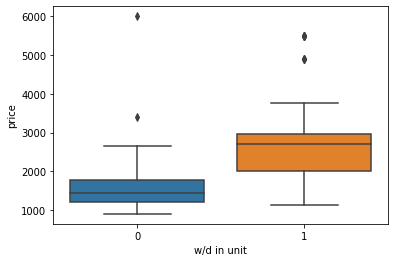

In [29]:
#@title Default title text

attribute = "w/d in unit" #@param ["cats are OK - purrr", "dogs are OK - wooof", "air conditioning", "furnished", "w/d in unit", "laundry on site", "no laundry on site", "no parking", "off-street parking", "detached garage"]
sns.boxplot(x=listingdf[attribute], y=listingdf['price'])
present = (listingdf[listingdf[attribute]==1]['dpsf']).mean()
without = (listingdf[listingdf[attribute]==0]['dpsf']).mean()
print(attribute)
print("Present: "+str(round(present, 4)))
print("Without: "+str(round(without, 4)))
print("Difference: "+ str(round(present-without, 4)))